# Temporal Wrapper

These examples demonstrate how to use the `TemporalWrapper` to process temporal inputs with a non-temporal backbone (e.g., TerraMind). They show how to integrate the TemporalWrapper into TerraTorch encoder–decoder pipelines and explain three pooling methods: `mean`, `concat`, and `diff`.

Each pooling method can operate directly on the temporal dimension or after subset-based averaging using `subset_lengths`; the `diff` example below illustrates this in practice.

See full documentation here: [TemporalWrapper — TerraTorch](https://ibm.github.io/terratorch/stable/guide/temporal_wrapper/)

## Data

We download a subset of a temporal crop dataset and build a TerraTorch Dataloader.

In [1]:
import gdown
import os

# Download a random subset for demos (~1 GB)
if not os.path.isfile('multi-temporal-crop-classification-subset.tar.gz'):
    gdown.download("https://drive.google.com/uc?id=1SycflNslu47yfMg2i_z8FqYkhZQv7JQM")

if not os.path.isdir('multi-temporal-crop-classification-subset/'):
    !tar -xzvf multi-temporal-crop-classification-subset.tar.gz

dataset_path = "multi-temporal-crop-classification-subset"

In [2]:
!ls "{dataset_path}"

training_chips      training_data.txt   validation_chips    validation_data.txt


In [3]:
import os
import sys
import torch
import gdown
import terratorch
import albumentations
import lightning.pytorch as pl
import matplotlib.pyplot as plt
from terratorch.datamodules import MultiTemporalCropClassificationDataModule
import warnings
warnings.filterwarnings('ignore')

# Adjusted dataset class for this dataset (general dataset could be used as well)
datamodule = MultiTemporalCropClassificationDataModule(
    batch_size=8,
    num_workers=2,
    data_root=dataset_path,
    train_transform=[
        terratorch.datasets.transforms.FlattenTemporalIntoChannels(),  # Required for temporal data
        albumentations.D4(), # Random flips and rotation
        albumentations.pytorch.transforms.ToTensorV2(),
        terratorch.datasets.transforms.UnflattenTemporalFromChannels(n_timesteps=3),
    ],
    val_transform=None,  # Using ToTensor() by default
    test_transform=None,
    expand_temporal_dimension=True,
    use_metadata=False, # The crop dataset has metadata for location and time
    reduce_zero_label=True,
)

# Setup train and val datasets
datamodule.setup("fit")

/Users/isw/miniconda3/envs/tt_pr312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/isw/miniconda3/envs/tt_pr312/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/Users/isw/miniconda3/envs/tt_pr312/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The '

In [4]:
train_dataset = datamodule.train_dataset
len(train_dataset)

462

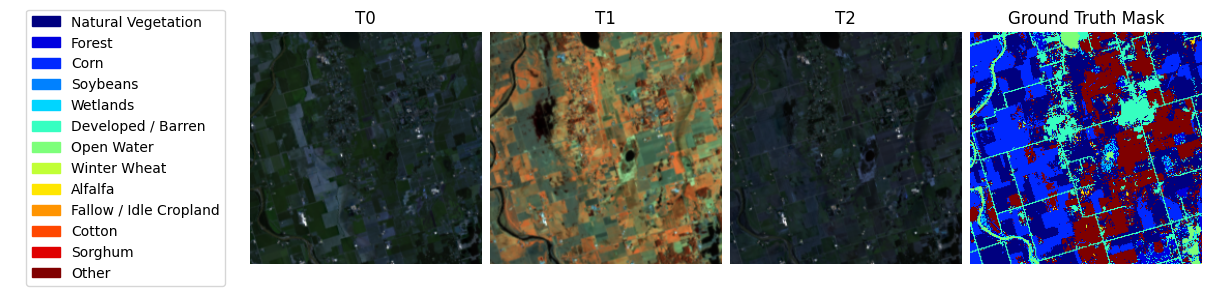

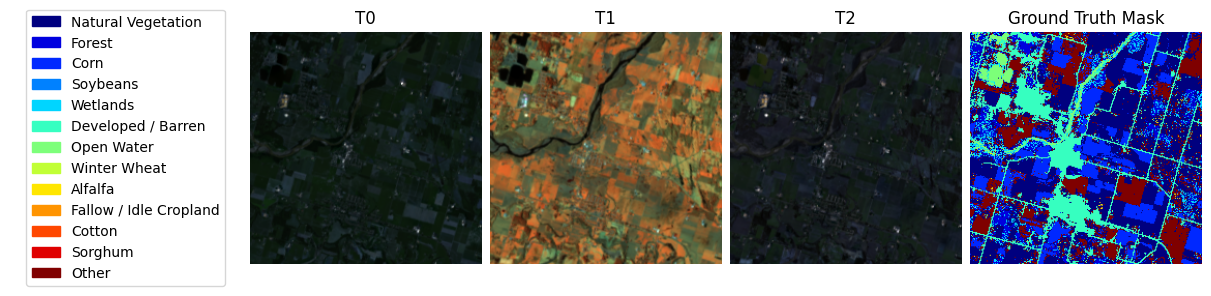

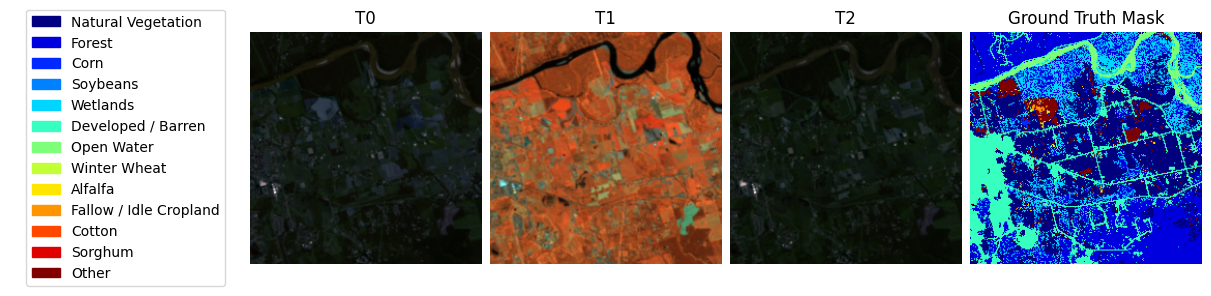

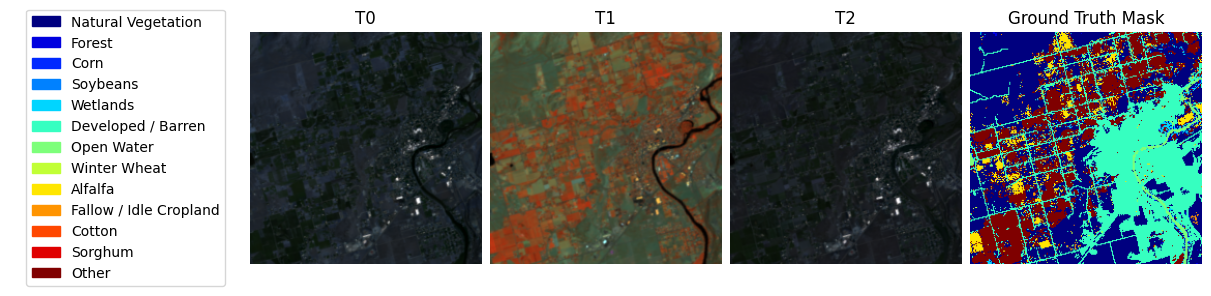

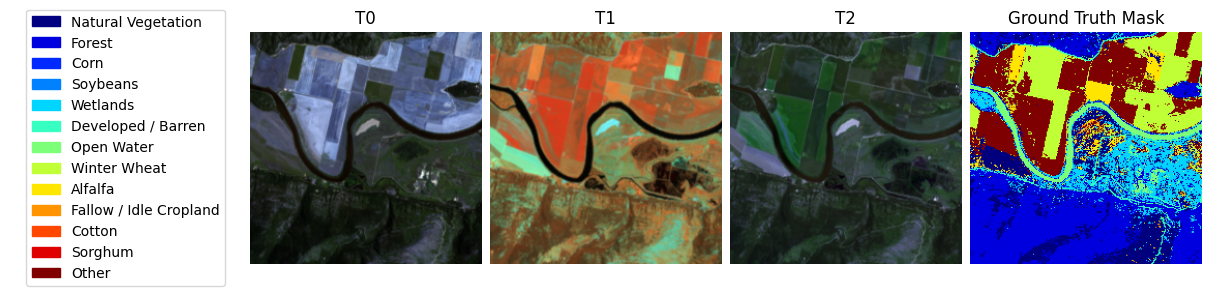

In [5]:
# plotting a few samples
for i in range(5):
    train_dataset.plot(train_dataset[i])

## Integrating the Temporal Wrapper

### Wrapping a backbone

The `TemporalWrapper` can be combined with any TerraTorch backbone by wrapping it as shown below. It can also be directly integrated into encoder–decoder pipelines, which we illustrate next through three example setups (Option 1-3).

In [6]:
from terratorch.registry import BACKBONE_REGISTRY
from terratorch.models.utils import TemporalWrapper

backbone = BACKBONE_REGISTRY.build(
    "terramind_v1_small",
    modalities=["S2L2A"],
    pretrained=True,
)

temporal_backbone = TemporalWrapper(backbone, pooling="mean")

temporal_backbone

TemporalWrapper(
  (encoder): TerraMindViT(
    (encoder_embeddings): ModuleDict(
      (untok_sen2l2a@224): ImageEncoderEmbedding(
        (proj): Linear(in_features=3072, out_features=384, bias=False)
      )
    )
    (encoder): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm()
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm()
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (encoder_norm): LayerNorm()
    (tokenizer): ModuleDict()
  )
)

### Option 1: Temporal Wrapper — Mean Pooling

We use the `TemporalWrapper` with `pooling="mean"` (the default) and enable it by passing `backbone_use_temporal=True`, which wraps the non-temporal TerraMind backbone to handle temporal inputs.

With mean pooling, the model averages features across timesteps:
- Each timestep (`t0`, `t1`, `t2`, …) is passed individually through the backbone.  
- The resulting latent representations are mean-averaged before being passed to the neck and decoder (here, a `UNetDecoder`).  

We set `freeze_backbone=True` for faster training; in practice, unfreezing the backbone typically improves performance.


In [7]:
# Option 1: Mean
model = terratorch.tasks.SemanticSegmentationTask(
    model_factory="EncoderDecoderFactory",
    model_args={
        # TerraMind backbone
        "backbone": "terramind_v1_small",
        "backbone_pretrained": True,
        "backbone_modalities": ["S2L2A"],
        "backbone_bands": {"S2L2A": ["BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2"]},

        # Apply temporal wrapper (params are passed with prefix backbone_temporal)
        "backbone_use_temporal": True,
        "backbone_temporal_pooling": "mean",  # Defaults to "mean" which also supports flexible input lengths
        
        # Necks 
        "necks": [
            {
                "name": "SelectIndices",
                "indices": [2, 5, 8, 11] # indices for terramind_v1_tiny, small, and base
                # "indices": [5, 11, 17, 23] # indices for terramind_v1_large
            },
            {
                "name": "ReshapeTokensToImage",
                "remove_cls_token": False,
            },
            {"name": "LearnedInterpolateToPyramidal"},            
        ],
        
        # Decoder
        "decoder": "UNetDecoder",
        "decoder_channels": [512, 256, 128, 64],
        
        # Head
        "head_dropout": 0.1,
        "num_classes": 13,
    },
    
    loss="ce",
    lr=1e-4, # The optimal learning rate varies between datasets, we recommend testing different once between 1e-5 and 1e-4. You can perform hyperparameter optimization using terratorch-iterate.
    optimizer="AdamW",
    ignore_index=-1,
    freeze_backbone=True,  # Speeds up fine-tuning
    freeze_decoder=False,
    plot_on_val=True,
    class_names=["Natural Vegetation", "Forest", "Corn", "Soybeans", "Wetlands", "Developed / Barren", "Open Water", "Winter Wheat", "Alfalfa", "Fallow / Idle Cropland", "Cotton", "Sorghum", "Other"],)

INFO:root:Loaded weights for BLUE in position 0 of patch embed
INFO:root:Loaded weights for GREEN in position 1 of patch embed
INFO:root:Loaded weights for RED in position 2 of patch embed
INFO:root:Loaded weights for NIR_NARROW in position 3 of patch embed
INFO:root:Loaded weights for SWIR_1 in position 4 of patch embed
INFO:root:Loaded weights for SWIR_2 in position 5 of patch embed


In [10]:
### Inspecting Model Pipeline with Mean Pooling

sample = train_dataset[0]
x = sample["image"].unsqueeze(0)  # [1, C, T, H, W], batch size=1

with torch.no_grad():
    feats = model.model.encoder(x)

print("Model Pipeline — Mean Pooling")
print("------------------------------")
print(f"Input shape:          {tuple(x.shape)}  [B, C, T, H, W] → Batch size 1, 6 channels, 3 timesteps")
print(f"Backbone:             {model.hparams['model_args']['backbone']}")
print(f"Temporal pooling:     {model.hparams['model_args']['backbone_temporal_pooling']}")
print(f"Encoder feature maps: {len(feats)}")
print(f"Feature map shape:  {tuple(feats[0].shape)}")

print(
    "\nThe TerraMind ViT-Small backbone returns a feature map per transformer block "
    "(12 in total), each with 196 spatial tokens and 384-dimensional embeddings."
)
print(
    "Mean pooling averages features across the 3 timesteps before they are passed "
    "into the U-Net decoder."
)

n_params_total = sum(p.numel() for p in model.parameters()) / 1e6
n_params_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6
print("\nModel Parameters")
print("----------------")
print(f"Total parameters:     {n_params_total:.2f}M")
print(f"Trainable (decoder):  {n_params_trainable:.2f}M")


Model Pipeline — Mean Pooling
------------------------------
Input shape:          (1, 6, 3, 224, 224)  [B, C, T, H, W] → Batch size 1, 6 channels, 3 timesteps
Backbone:             terramind_v1_small
Temporal pooling:     mean
Encoder feature maps: 12
Feature map shape:  (1, 196, 384)

The TerraMind ViT-Small backbone returns a feature map per transformer block (12 in total), each with 196 spatial tokens and 384-dimensional embeddings.
Mean pooling averages features across the 3 timesteps before they are passed into the U-Net decoder.

Model Parameters
----------------
Total parameters:     31.32M
Trainable (decoder):  9.44M


### Option 2: Temporal Wrapper — Concat Pooling

In this setup, the `TemporalWrapper` concatenates features from all timesteps in the latent space instead of averaging them. This increases the channel dimension by the number of timesteps (3 in this example).

It is necessary to set `"n_timestamps": 3` so the model can construct the correct decoder model.  

Since the decoder now receives a larger input (×3 channels), this configuration results in a higher parameter count compared to mean pooling.


In [11]:
# Option 2: Concat
model = terratorch.tasks.SemanticSegmentationTask(
    model_factory="EncoderDecoderFactory",
    model_args={
        # TerraMind backbone
        "backbone": "terramind_v1_small",
        "backbone_pretrained": True,
        "backbone_modalities": ["S2L2A"],
        "backbone_bands": {"S2L2A": ["BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2"]},

        # Apply temporal wrapper (params are passed with prefix backbone_temporal)
        "backbone_use_temporal": True,
        "backbone_temporal_pooling": "concat",
        "backbone_temporal_n_timestamps": 3,  # Required for pooling = concat
        
        # Necks 
        "necks": [
            {
                "name": "SelectIndices",
                "indices": [2, 5, 8, 11] # indices for terramind_v1_tiny, small, and base
                # "indices": [5, 11, 17, 23] # indices for terramind_v1_large
            },
            {
                "name": "ReshapeTokensToImage",
                "remove_cls_token": False,
            },
            {"name": "LearnedInterpolateToPyramidal"},            
        ],
        
        # Decoder
        "decoder": "UNetDecoder",
        "decoder_channels": [512, 256, 128, 64],
        
        # Head
        "head_dropout": 0.1,
        "num_classes": 13,
    },
    
    loss="ce",
    lr=1e-4, # The optimal learning rate varies between datasets, we recommend testing different once between 1e-5 and 1e-4. You can perform hyperparameter optimization using terratorch-iterate.
    optimizer="AdamW",
    ignore_index=-1,
    freeze_backbone=True,  # Speeds up fine-tuning
    freeze_decoder=False,
    plot_on_val=True,
    class_names=["Natural Vegetation", "Forest", "Corn", "Soybeans", "Wetlands", "Developed / Barren", "Open Water", "Winter Wheat", "Alfalfa", "Fallow / Idle Cropland", "Cotton", "Sorghum", "Other"],)

INFO:root:Loaded weights for BLUE in position 0 of patch embed
INFO:root:Loaded weights for GREEN in position 1 of patch embed
INFO:root:Loaded weights for RED in position 2 of patch embed
INFO:root:Loaded weights for NIR_NARROW in position 3 of patch embed
INFO:root:Loaded weights for SWIR_1 in position 4 of patch embed
INFO:root:Loaded weights for SWIR_2 in position 5 of patch embed


In [14]:
### Inspecting Model Pipeline with Concat Pooling

model.eval()
sample = train_dataset[0]
x = sample["image"].unsqueeze(0)  # [1, C, T, H, W], batch size=1

with torch.no_grad():
    feats = model.model.encoder(x)

print("Model Pipeline — Concat Pooling")
print("-------------------------------")
print(f"Input shape:          {tuple(x.shape)}  [B, C, T, H, W] → Batch size 1, 6 channels, 3 timesteps")
print(f"Backbone:             {model.hparams['model_args']['backbone']}")
print(f"Temporal pooling:     {model.hparams['model_args']['backbone_temporal_pooling']}")
print(f"Encoder feature maps: {len(feats)}")
print(f"Example feature map:  {tuple(feats[0].shape)}")

print(
    "\nThe TerraMind ViT-Small backbone returns a feature map per transformer "
    "block (12 total), each with 196 spatial tokens and 384-dimensional embeddings."
)
print(
    "Concat pooling stacks the features from all 3 timesteps along the channel "
    "dimension (now 1152-dim) before passing them to the U-Net decoder, increasing the decoder’s "
    "input size and number of parameters."
)

n_params_total = sum(p.numel() for p in model.parameters()) / 1e6
n_params_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6
print("\nModel Parameters")
print("----------------")
print(f"Total parameters:     {n_params_total:.2f}M")
print(f"Trainable (decoder):  {n_params_trainable:.2f}M")


Model Pipeline — Concat Pooling
-------------------------------
Input shape:          (1, 6, 3, 224, 224)  [B, C, T, H, W] → Batch size 1, 6 channels, 3 timesteps
Backbone:             terramind_v1_small
Temporal pooling:     concat
Encoder feature maps: 12
Example feature map:  (1, 196, 1152)

The TerraMind ViT-Small backbone returns a feature map per transformer block (12 total), each with 196 spatial tokens and 384-dimensional embeddings.
Concat pooling stacks the features from all 3 timesteps along the channel dimension (now 1152-dim) before passing them to the U-Net decoder, increasing the decoder’s input size and number of parameters.

Model Parameters
----------------
Total parameters:     44.81M
Trainable (decoder):  22.94M


### Option 3: Temporal Wrapper — Diff with Subset Averaging

This mode computes the difference between two temporal elements. If `subset_lengths` is
provided, the wrapper first averages within each defined subset before applying the
difference. For example, with three timesteps and `subset_lengths=[1, 2]`, the first
timestep (`t₀`) forms the first subset and the remaining two (`t₁`, `t₂`) form the
second. The wrapper returns the difference between the two subset means.

After differencing, the representation retains the same shape as a single timestep,
so decoder input size and total parameter count remain unchanged compared to mean pooling.


In [15]:
# Option 3: Diff with Subset Averaging

model = terratorch.tasks.SemanticSegmentationTask(
    model_factory="EncoderDecoderFactory",
    model_args={
        # TerraMind backbone
        "backbone": "terramind_v1_small",
        "backbone_pretrained": True,
        "backbone_modalities": ["S2L2A"],
        "backbone_bands": {"S2L2A": ["BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2"]},

        # Apply temporal wrapper (params are passed with prefix backbone_temporal)
        "backbone_use_temporal": True,
        "backbone_temporal_pooling": "diff",
        "backbone_temporal_subset_lengths": [1, 2],  # First timestep vs mean of timesteps 2–3

        
        # Necks 
        "necks": [
            {
                "name": "SelectIndices",
                "indices": [2, 5, 8, 11] # indices for terramind_v1_tiny, small, and base
                # "indices": [5, 11, 17, 23] # indices for terramind_v1_large
            },
            {
                "name": "ReshapeTokensToImage",
                "remove_cls_token": False,
            },
            {"name": "LearnedInterpolateToPyramidal"},            
        ],
        
        # Decoder
        "decoder": "UNetDecoder",
        "decoder_channels": [512, 256, 128, 64],
        
        # Head
        "head_dropout": 0.1,
        "num_classes": 13,
    },
    
    loss="ce",
    lr=1e-4, # The optimal learning rate varies between datasets, we recommend testing different once between 1e-5 and 1e-4. You can perform hyperparameter optimization using terratorch-iterate.
    optimizer="AdamW",
    ignore_index=-1,
    freeze_backbone=True,  # Speeds up fine-tuning
    freeze_decoder=False,
    plot_on_val=True,
    class_names=["Natural Vegetation", "Forest", "Corn", "Soybeans", "Wetlands", "Developed / Barren", "Open Water", "Winter Wheat", "Alfalfa", "Fallow / Idle Cropland", "Cotton", "Sorghum", "Other"],)

INFO:root:Loaded weights for BLUE in position 0 of patch embed
INFO:root:Loaded weights for GREEN in position 1 of patch embed
INFO:root:Loaded weights for RED in position 2 of patch embed
INFO:root:Loaded weights for NIR_NARROW in position 3 of patch embed
INFO:root:Loaded weights for SWIR_1 in position 4 of patch embed
INFO:root:Loaded weights for SWIR_2 in position 5 of patch embed


In [16]:
### Inspecting Model Pipeline with Diff Subsets Pooling

model.eval()
sample = train_dataset[0]
x = sample["image"].unsqueeze(0)  # [1, C, T, H, W]

with torch.no_grad():
    feats = model.model.encoder(x)

print("Model Pipeline — Diff Subsets Pooling")
print("--------------------------------------")
print(f"Input shape:          {tuple(x.shape)}  [B, C, T, H, W] → Batch size 1, 6 channels, 3 timesteps")
print(f"Backbone:             {model.hparams['model_args']['backbone']}")
print(f"Temporal pooling:     {model.hparams['model_args']['backbone_temporal_pooling']}")
print(f"Encoder feature maps: {len(feats)}")
print(f"Example feature map:  {tuple(feats[0].shape)}")

print(
    "\nThe 12 intermediate layers of the TerraMind ViT-Small backbone each produce "
    "a feature map of 196 tokens with 384 dimensions."
)
print(
    "Diff subsets pooling computes the difference between the mean of two temporal subsets"
    " and returns a single feature representation with the same shape as a single timestep."
    "This keeps the decoder size and parameter count identical to mean pooling."
)


n_params_total = sum(p.numel() for p in model.parameters()) / 1e6
n_params_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6
print("\nModel Parameters")
print("----------------")
print(f"Total parameters:     {n_params_total:.2f}M")
print(f"Trainable (decoder):  {n_params_trainable:.2f}M")



Model Pipeline — Diff Subsets Pooling
--------------------------------------
Input shape:          (1, 6, 3, 224, 224)  [B, C, T, H, W] → Batch size 1, 6 channels, 3 timesteps
Backbone:             terramind_v1_small
Temporal pooling:     diff
Encoder feature maps: 12
Example feature map:  (1, 196, 384)

The 12 intermediate layers of the TerraMind ViT-Small backbone each produce a feature map of 196 tokens with 384 dimensions.
Diff subsets pooling computes the difference between the mean of two temporal subsets and returns a single feature representation with the same shape as a single timestep.This keeps the decoder size and parameter count identical to mean pooling.

Model Parameters
----------------
Total parameters:     31.32M
Trainable (decoder):  9.44M


## Training

The constructed encoder–decoder pipelines and wrapped backbones can be trained in the same way as single-timestep or non-wrapped models.

In [17]:
pl.seed_everything(0)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath="output/terramind_base_multicrop/checkpoints/",
    mode="min",
    monitor="val/loss",
    filename="best-loss",
    save_weights_only=True,
)

# Lightning Trainer
trainer = pl.Trainer(
    accelerator="auto",
    strategy="auto",
    devices=1, # Lightning multi-gpu often fails in notebooks
    precision='16-mixed',  # Speed up training
    num_nodes=1,
    logger=True, # Uses TensorBoard by default
    max_epochs=3, # For demos
    log_every_n_steps=1,
    callbacks=[checkpoint_callback, pl.callbacks.RichProgressBar()],
    default_root_dir="output/terramind_base_multicrop",
)

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0
INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (mps), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (mps), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# Training
trainer.fit(model, datamodule=datamodule)